## Initial setup

Let's now initialize a few variables that we'll need throughout the notebook:

In [20]:
import boto3
import sagemaker

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

print(region)

eu-north-1


## Session 1

In this session we'll run Exploratory Data Analysis on the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data) and we'll build a simple [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with one step to split and transform the data. 

<a href="../images/training.png" target="_blank"> <img src="../images/training.png" alt="Training" style="max-width: 750px;" /></a>

We'll use a [Scikit-Learn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for the transformations, and a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) with a [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) to execute a preprocessing script. Check the [SageMaker Pipelines Overview](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) for an introduction to the fundamental components of a SageMaker Pipeline.


### Step 1 - Exploratory Data Analysis

Let's run Exploratory Data Analysis on the dataset. The goal of this section is to understand the data and the problem we are trying to solve.

Let's load the Penguins dataset:

In [21]:
import pandas as pd
import numpy as np

#Retreive csv from S3

DATA_FILEPATH = "../penguins.csv"
penguins = pd.read_csv(DATA_FILEPATH)

penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


We can see the dataset contains the following columns:

1. `species`: The species of a penguin. This is the column we want to predict.
2. `island`: The island where the penguin was found
3. `culmen_length_mm`: The length of the penguin's culmen (bill) in millimeters
4. `culmen_depth_mm`: The depth of the penguin's culmen in millimeters
5. `flipper_length_mm`: The length of the penguin's flipper in millimeters
6. `body_mass_g`: The body mass of the penguin in grams
7. `sex`: The sex of the penguin


Let's now display the distribution of values for the three categorical columns in our data:

In [22]:
species_distribution = penguins["species"].value_counts()
island_distribution = penguins["island"].value_counts()
sex_distribution = penguins["sex"].value_counts()

print(species_distribution)
print()
print(island_distribution)
print()
print(sex_distribution)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64


The distribution of the categories in our data are:

-   `species`: There are 3 species of penguins in the dataset: Adelie (152), Gentoo (124), and Chinstrap (68).
-   `island`: Penguins are from 3 islands: Biscoe (168), Dream (124), and Torgersen (52).
-   `sex`: We have 168 male penguins, 165 female penguins, and 1 penguin with an ambiguous gender ('.').

Note: The rows with NaN values in the sex category are not showcased in the distribution.

Let's replace the ambiguous value in the `sex` column with a null (NaN) value:

In [23]:
penguins["sex"] = penguins["sex"].replace(".", np.nan)
penguins.to_csv("../clean_penguins.csv", header=True, index=False)

# Store clean csv in S3

penguins["sex"].value_counts()

sex
MALE      168
FEMALE    165
Name: count, dtype: int64

Next, let's check for any missing values (NaN) in the dataset.

In [24]:
penguins.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Let's get rid of the missing values. For now, we are going to replace the missing values with the most frequent value in the column. Later, we'll use a different strategy to replace missing numeric values.

In [25]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:, :] = imputer.fit_transform(penguins)

penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,41.1,17.0,190.0,3800.0,MALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


Let's visualize the distribution of categorical features.

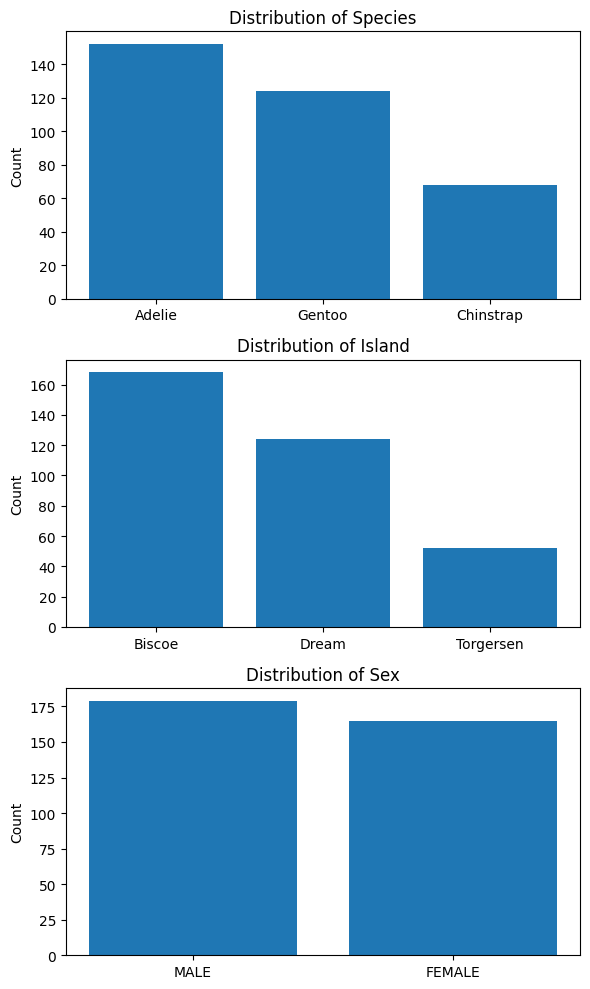

In [26]:
import matplotlib.pyplot as plt

# New distributions of features after replacing the missing values
species_distribution = penguins["species"].value_counts()
island_distribution = penguins["island"].value_counts()
sex_distribution = penguins["sex"].value_counts()

fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].bar(species_distribution.index, species_distribution.values)
axs[0].set_ylabel("Count")
axs[0].set_title("Distribution of Species")

axs[1].bar(island_distribution.index, island_distribution.values)
axs[1].set_ylabel("Count")
axs[1].set_title("Distribution of Island")

axs[2].bar(sex_distribution.index, sex_distribution.values)
axs[2].set_ylabel("Count")
axs[2].set_title("Distribution of Sex")

plt.tight_layout()
plt.show()

Let's visualize the distribution of numerical columns.

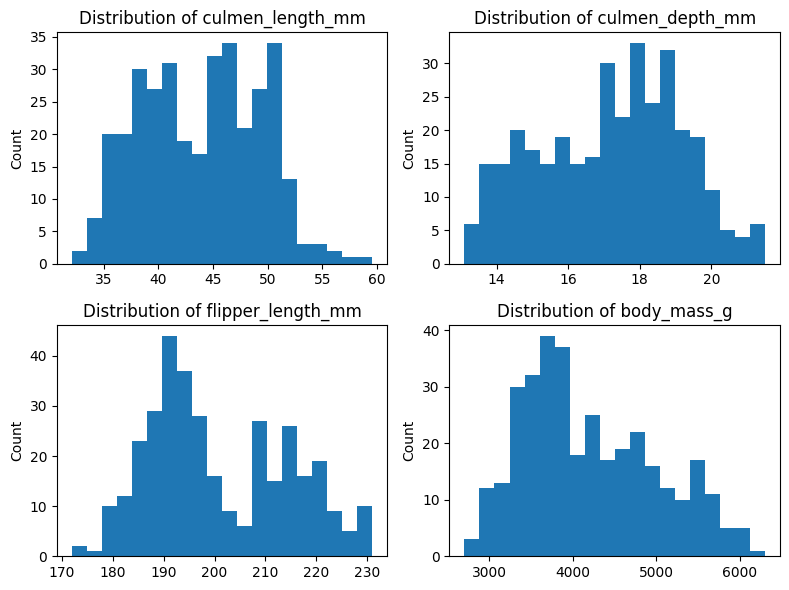

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].hist(penguins["culmen_length_mm"], bins=20)
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_title("Distribution of culmen_length_mm")

axs[0, 1].hist(penguins["culmen_depth_mm"], bins=20)
axs[0, 1].set_ylabel("Count")
axs[0, 1].set_title("Distribution of culmen_depth_mm")

axs[1, 0].hist(penguins["flipper_length_mm"], bins=20)
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_title("Distribution of flipper_length_mm")

axs[1, 1].hist(penguins["body_mass_g"], bins=20)
axs[1, 1].set_ylabel("Count")
axs[1, 1].set_title("Distribution of body_mass_g")

plt.tight_layout()
plt.show()

Let's display the covariance matrix of the dataset. The "covariance" measures how changes in one variable are associated with changes in a second variable. In other words, the covariance measures the degree to which two variables are linearly associated.

In [28]:
penguins.cov(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,29.679415,-2.516984,50.260588,2596.971151
culmen_depth_mm,-2.516984,3.877201,-16.108849,-742.660180
flipper_length_mm,50.260588,-16.108849,197.269501,9792.552037
body_mass_g,2596.971151,-742.660180,9792.552037,640316.716388


Let's now display the correlation matrix. "Correlation" measures both the strength and direction of the linear relationship between two variables.

In [29]:
penguins.corr(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.234635,0.656856,0.595720
culmen_depth_mm,-0.234635,1.000000,-0.582472,-0.471339
flipper_length_mm,0.656856,-0.582472,1.000000,0.871302
body_mass_g,0.595720,-0.471339,0.871302,1.000000


Here are three examples of what we get from interpreting the correlation matrix below:

1. Penguins that weight more tend to have larger flippers.
2. Penguins with a long culmen tend to have smaller flippers.
3. The length and depth of the culmen have a slight negative correlation.

If we are in a Regression problem (that is, predicting the value of the target using the rest of the features as input) we can detect with this correlation matrix which features are non-relevant and can be omited in the training phase. For example, redundant features can be eliminated (they don't add new information). Also, we are interested in features that have linear or inverse relationships with the target. In a classification problem this is not possible, as the target is categorical and not numerical, hence it cannot be included in the correlation matrix.

After the feature selection is done, it's possible to apply PCA or a similar technique which allows to reduce as much as possible the dimensionality of the problem. A reduced dimensionality allows the model to better understand the data patterns behind the dataset.

### Step 2 - Creating the Preprocessing Script

The first step we need in the pipeline is a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) to run a script that will split and transform the data. This Processing Step will create a SageMaker Processing Job in the background, run the script, and upload the output to S3. You can use Processing Jobs to perform data preprocessing, post-processing, feature engineering, data validation, and model evaluation. Check the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) SageMaker's SDK documentation for more information.

The first step is to create the script that will split and transform the input data.

In [30]:
%%writefile preprocessor.py

import os
import tarfile
import tempfile
import joblib
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder


def preprocess(base_directory):
    """
    This function loads the supplied data, splits it and transforms it.
    """

    df = _read_data_from_input_csv_files(base_directory)
    
    target_transformer = ColumnTransformer(
        transformers=[("species", OrdinalEncoder(), [0])]
    )
    
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler()
    )

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder()
    )
    
    features_transformer = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, make_column_selector(dtype_exclude="object")),
            ("categorical", categorical_transformer, ["island", "sex"]),
        ]
    )

    df_train, df_validation, df_test = _split_data(df)

    _save_baselines(base_directory, df_train, df_test)

    y_train = target_transformer.fit_transform(np.array(df_train.species.values).reshape(-1, 1))
    y_validation = target_transformer.transform(np.array(df_validation.species.values).reshape(-1, 1))
    y_test = target_transformer.transform(np.array(df_test.species.values).reshape(-1, 1))
    
    df_train = df_train.drop("species", axis=1)
    df_validation = df_validation.drop("species", axis=1)
    df_test = df_test.drop("species", axis=1)

    X_train = features_transformer.fit_transform(df_train)
    X_validation = features_transformer.transform(df_validation)
    X_test = features_transformer.transform(df_test)

    _save_splits(base_directory, X_train, y_train, X_validation, y_validation, X_test, y_test)
    _save_model(base_directory, target_transformer, features_transformer)
    

def _read_data_from_input_csv_files(base_directory):
    """
    This function reads every CSV file available and concatenates
    them into a single dataframe.
    """

    input_directory = Path(base_directory) / "input"
    files = [file for file in input_directory.glob("*.csv")]
    
    if len(files) == 0:
        raise ValueError(f"The are no CSV files in {str(input_directory)}/")
        
    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)
    
    # Shuffle the data
    return df.sample(frac=1, random_state=42)


def _split_data(df):
    """
    Splits the data into three sets: train, validation and test.
    """

    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    return df_train, df_validation, df_test


def _save_baselines(base_directory, df_train, df_test):
    """
    During the data and quality monitoring steps, we will need baselines
    to compute constraints and statistics. This function saves the 
    untransformed data to disk so we can use them as baselines later.
    """

    for split, data in [("train", df_train), ("test", df_test)]:
        baseline_path = Path(base_directory) / f"{split}-baseline"
        baseline_path.mkdir(parents=True, exist_ok=True)

        df = data.copy().dropna()

        # We want to save the header only for the train baseline
        # but not for the test baseline. We'll use the test baseline
        # to generate predictions later, and we can't have a header line
        # because the model won't be able to make a prediction for it.

        if split == "train":
            header = True
        else:
            header = False
            
        df.to_csv(baseline_path / f"{split}-baseline.csv", header=header, index=False)


def _save_splits(base_directory, X_train, y_train, X_validation, y_validation, X_test, y_test):
    """
    This function concatenates the transformed features and the target variable, and
    saves each one of the split sets to disk.
    """

    train = np.concatenate((X_train, y_train), axis=1)
    validation = np.concatenate((X_validation, y_validation), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(validation_path / "validation.csv", header=False, index=False)
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_model(base_directory, target_transformer, features_transformer):
    """
    This function creates a model.tar.gz file that contains the two transformation
    pipelines we built to transform the data.
    """

    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, os.path.join(directory, "target.joblib"))
        joblib.dump(features_transformer, os.path.join(directory, "features.joblib"))
    
        model_path = Path(base_directory) / "model"
        model_path.mkdir(parents=True, exist_ok=True)
    
        with tarfile.open(f"{str(model_path / 'model.tar.gz')}", "w:gz") as tar:
            tar.add(os.path.join(directory, "target.joblib"), arcname="target.joblib")
            tar.add(os.path.join(directory, "features.joblib"), arcname="features.joblib")

    
if __name__ == "__main__":
    preprocess(base_directory="/opt/ml/processing")

Overwriting preprocessor.py


Let's test the script to ensure everything is working as expected:

In [31]:
import ipytest
from pathlib import Path

ipytest.autoconfig(raise_on_error=True)

In [32]:
%%ipytest -s

import os
import shutil
import tarfile
import pytest
import tempfile
import joblib
from preprocessor import preprocess

# Remember to get rid of ambiguous values (convert them to NaN instead) 
DATA_FILEPATH = "../clean_penguins.csv"  

@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    preprocess(base_directory=directory)
    
    yield directory
    
    shutil.rmtree(directory)


def test_preprocess_generates_data_splits(directory):
    output_directories = os.listdir(directory)
    
    assert "train" in output_directories
    assert "validation" in output_directories
    assert "test" in output_directories


def test_preprocess_generates_baselines(directory):
    output_directories = os.listdir(directory)

    assert "train-baseline" in output_directories
    assert "test-baseline" in output_directories


def test_preprocess_creates_two_models(directory):
    model_path = directory / "model"
    tar = tarfile.open(model_path / "model.tar.gz", "r:gz")

    assert "features.joblib" in tar.getnames()
    assert "target.joblib" in tar.getnames()


def test_splits_are_transformed(directory):
    train = pd.read_csv(directory / "train" / "train.csv", header=None)
    validation = pd.read_csv(directory / "validation" / "validation.csv", header=None)
    test = pd.read_csv(directory / "test" / "test.csv", header=None)

    # After transforming the data, the number of features should be 7:
    # * 3 - island (one-hot encoded)
    # * 1 - culmen_length_mm = 1
    # * 1 - culmen_depth_mm
    # * 1 - flipper_length_mm
    # * 1 - body_mass_g
    number_of_features = 9

    # The transformed splits should have an additional column for the target
    # variable.
    assert train.shape[1] == number_of_features + 1
    assert validation.shape[1] == number_of_features + 1
    assert test.shape[1] == number_of_features + 1


def test_train_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(directory / "train-baseline" / "train-baseline.csv", header=None)

    island = baseline.iloc[:, 1].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_test_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(directory / "test-baseline" / "test-baseline.csv", header=None)

    island = baseline.iloc[:, 1].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_train_baseline_includes_header(directory):
    baseline = pd.read_csv(directory / "train-baseline" / "train-baseline.csv")
    assert baseline.columns[0] == "species"


def test_test_baseline_does_not_include_header(directory):
    baseline = pd.read_csv(directory / "test-baseline" / "test-baseline.csv")
    assert baseline.columns[0] != "species"

...

.....
8 passed in 0.17s


### Step 3 - Setting up the Processing Step

Let's now define the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) that we'll use in the pipeline to run the script that will split and transform the data.

Several SageMaker Pipeline steps support caching. When a step runs, and dependending on the configured caching policy, SageMaker will try to reuse the result of a previous successful run of the same step. You can find more information about this topic in [Caching Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-caching.html). Let's define a caching policy that we'll reuse on every step:


In [36]:
from sagemaker.workflow.steps import CacheConfig

cache_config = CacheConfig(enable_caching=True, expire_after="15d")

We can parameterize a SageMaker Pipeline to make it more flexible. In this case, we'll use a paramater to pass the location of the dataset we want to process. We can execute the pipeline with different datasets by changing the value of this parameter. To read more about these parameters, check [Pipeline Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html).

Let's load the S3 bucket name from the environment variables:

In [37]:
from sagemaker.workflow.parameters import ParameterString
import os

bucket = os.environ["BUCKET"]
S3_LOCATION = f"s3://{bucket}/penguins"

dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data",
)


Let's create a configuration dictionary:

In [55]:
import logging
from sagemaker.workflow.pipeline_context import PipelineSession

pipeline_session = PipelineSession(default_bucket=bucket)

config = {
    "session": pipeline_session,
    "instance_type": "ml.m5.xlarge",
    "image": None,
    "framework_version": "2.11",
    "py_version": "py39",
}

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

A processor gives the Processing Step information about the hardware and software that SageMaker should use to launch the Processing Job. To run the script we created, we need access to Scikit-Learn, so we can use the [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) processor that comes out-of-the-box with the SageMaker's Python SDK. The [Data Processing with Framework Processors](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html) page discusses other built-in processors you can use. The [Docker Registry Paths and Example Code](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) page contains information about the available framework versions for each region.

In [56]:
from sagemaker.sklearn.processing import SKLearnProcessor

role = os.environ["ROLE"]

processor = SKLearnProcessor(
    base_job_name="split-and-transform-data",
    framework_version="1.2-1",
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


Let's now define the Processing Step that we'll use in the pipeline. This step requires a list of inputs that we need on the preprocessing script. In this case, the input is the dataset we stored in S3. We also have a few outputs that we want SageMaker to capture when the Processing Job finishes.

In [57]:

from sagemaker.workflow.steps import ProcessingStep
from sagemaker.processing import ProcessingInput, ProcessingOutput


split_and_transform_data_step = ProcessingStep(
    name="split-and-transform-data",
    step_args=processor.run(
        code="/home/pousen/victor.ml.school/code/preprocessor.py",
        inputs=[
            ProcessingInput(
                source=dataset_location, destination="/opt/ml/processing/input"
            ),
        ],
        outputs=[
            ProcessingOutput(
                output_name="train",
                source="/opt/ml/processing/train",
                destination=f"{S3_LOCATION}/preprocessing/train",
            ),
            ProcessingOutput(
                output_name="validation",
                source="/opt/ml/processing/validation",
                destination=f"{S3_LOCATION}/preprocessing/validation",
            ),
            ProcessingOutput(
                output_name="test",
                source="/opt/ml/processing/test",
                destination=f"{S3_LOCATION}/preprocessing/test",
            ),
            ProcessingOutput(
                output_name="model",
                source="/opt/ml/processing/model",
                destination=f"{S3_LOCATION}/preprocessing/model",
            ),
            ProcessingOutput(
                output_name="train-baseline",
                source="/opt/ml/processing/train-baseline",
                destination=f"{S3_LOCATION}/preprocessing/train-baseline",
            ),
            ProcessingOutput(
                output_name="test-baseline",
                source="/opt/ml/processing/test-baseline",
                destination=f"{S3_LOCATION}/preprocessing/test-baseline",
            ),
        ],
    ),
    cache_config=cache_config,
)

/home/pousen/miniconda3/envs/mlschool/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Step 4 - Creating the Pipeline

We can now create the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [58]:
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig

pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

session1_pipeline = Pipeline(
    name="session1-pipeline",
    parameters=[dataset_location],
    steps=[
        split_and_transform_data_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session1_pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:eu-north-1:643784795563:pipeline/session1-pipeline',
 'ResponseMetadata': {'RequestId': 'a2a35882-53a9-476f-81a4-e120b6d200f2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a2a35882-53a9-476f-81a4-e120b6d200f2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '86',
   'date': 'Sun, 29 Oct 2023 18:55:57 GMT'},
  'RetryAttempts': 0}}

In [59]:
session1_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:eu-north-1:643784795563:pipeline/session1-pipeline/execution/i001ysi3t9en', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x7ff38b23e290>)